In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import inv_boxcox
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow import keras

In [2]:
dataPath = '../data/TfL dataset.xlsx'
veh1 = pd.read_excel(dataPath,sheet_name='veh.1')
veh1 = veh1.loc[:, ~veh1.columns.str.contains('^Unnamed')]
veh1.drop(veh1.index[0],inplace=True)
# veh1.drop(['Eng. Speed'],axis=1,inplace=True)

In [3]:
veh1.head()

,Test Time,Roll Speed,Eng. Speed,CO Mass,NOx Mass,CO2 Mass,driving cycle
1,0.1,0.056133,872.34,0,0.000004,0.32878,Urban-Free
2,1.1,0.019722,871.085,0,0.000004,0.332906,Urban-Free
3,2.1,0.046526,868.51,0,0.000004,0.331826,Urban-Free
4,3.1,0.035399,874.915,0,0.000005,0.326944,Urban-Free
5,4.1,0.049053,866.438,0,0.000002,0.324458,Urban-Free


In [4]:
veh1.shape

(14019, 7)

In [5]:
veh1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14019 entries, 1 to 14019
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Test Time       14019 non-null  object
 1   Roll Speed      14019 non-null  object
 2   Eng. Speed      14019 non-null  object
 3   CO Mass         14019 non-null  object
 4   NOx Mass        14019 non-null  object
 5   CO2 Mass        14019 non-null  object
 6   driving cycle   14019 non-null  object
dtypes: object(7)
memory usage: 876.2+ KB


there are no missing values in the dataset 

In [6]:
columns = veh1.columns
for col in columns:
    if col == 'driving cycle ':
        continue
    else:
        veh1[col] = veh1[col].astype('float')

In [7]:
veh1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14019 entries, 1 to 14019
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Test Time       14019 non-null  float64
 1   Roll Speed      14019 non-null  float64
 2   Eng. Speed      14019 non-null  float64
 3   CO Mass         14019 non-null  float64
 4   NOx Mass        14019 non-null  float64
 5   CO2 Mass        14019 non-null  float64
 6   driving cycle   14019 non-null  object 
dtypes: float64(6), object(1)
memory usage: 876.2+ KB


# Considering only one driving mode

In [8]:
# Considering only the urban free flow
uFree = veh1[veh1['driving cycle ']=='Urban-Free']
assert len(list(uFree['driving cycle '].unique()))==1
uFree.drop(['driving cycle '],axis=1,inplace=True)
uFree.head()

In [9]:
sns.pairplot(uFree)

NameError: name 'uFree' is not defined

<AxesSubplot:>

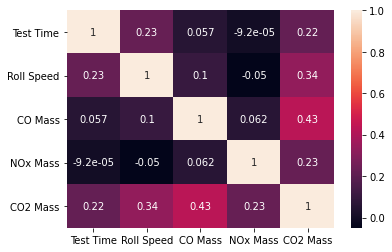

In [10]:
corr = uFree.corr()
sns.heatmap(corr,annot=True)

In [11]:
xtrain,xtest,ytrain,ytest = train_test_split(uFree[['Test Time','Roll Speed']].values,uFree[['CO Mass','NOx Mass','CO2 Mass']].values,shuffle=False,test_size=0.2)
print(f'xtrain shape is {xtrain.shape},xtest shape is {xtest.shape}')
print(f'ytrain shape is {ytrain.shape},ytest shape is {ytest.shape}')

xtrain shape is (961, 2),xtest shape is (241, 2)
ytrain shape is (961, 3),ytest shape is (241, 3)


In [12]:
scaler = MinMaxScaler()
scaler.fit(xtrain)
xtrainScaled = scaler.transform(xtrain)
xtestScaled = scaler.transform(xtest)

xtrainScaled = xtrainScaled.reshape(xtrainScaled.shape[0],1,xtrainScaled.shape[1])
xtestScaled = xtestScaled.reshape(xtestScaled.shape[0],1,xtestScaled.shape[1])

print(f'xtrain shape is {xtrainScaled.shape},xtest shape is {xtestScaled.shape}')

xtrain shape is (961, 1, 2),xtest shape is (241, 1, 2)


In [69]:
# Basic LSTM model

model = keras.Sequential()
model.add(keras.layers.LSTM(8,return_sequences=True,input_shape=(xtrainScaled.shape[1],xtrainScaled.shape[2])))
# model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(4))
model.add(keras.layers.Dropout(0.15))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(3))

model.compile(loss='mae',metrics=['mse'],optimizer='adam')

In [70]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 8)              352       
_________________________________________________________________
dense_20 (Dense)             (None, 1, 4)              36        
_________________________________________________________________
dropout_10 (Dropout)         (None, 1, 4)              0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 15        
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


In [71]:
history = model.fit(xtrainScaled,ytrain,validation_split=0.05,batch_size=32,epochs=200)

=================] - 0s 2ms/step - loss: 0.1066 - mse: 0.0752 - val_loss: 0.1898 - val_mse: 0.2085
Epoch 51/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1081 - mse: 0.0781 - val_loss: 0.1900 - val_mse: 0.2090
Epoch 52/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1169 - mse: 0.0843 - val_loss: 0.1895 - val_mse: 0.2116
Epoch 53/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1166 - mse: 0.0828 - val_loss: 0.1894 - val_mse: 0.2110
Epoch 54/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1135 - mse: 0.0844 - val_loss: 0.1891 - val_mse: 0.2087
Epoch 55/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1123 - mse: 0.0805 - val_loss: 0.1895 - val_mse: 0.2093
Epoch 56/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1149 - mse: 0.0860 - val_loss: 0.1891 - val_mse: 0.2116
Epoch 57/200
29/29 [==============================] - 0s 2ms/step - loss: 0.1091 - mse: 0.0777 - val_loss: 0.

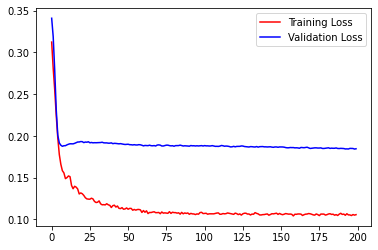

In [72]:
plt.plot(history.history['loss'],color='r',label='Training Loss')
plt.plot(history.history['val_loss'],color='b',label='Validation Loss')
plt.legend()
plt.show()

In [73]:
predictions = model.predict(xtestScaled)
print(predictions.shape)

(241, 3)


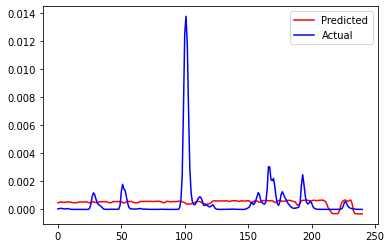

In [74]:
plt.plot(predictions[:,0],color='r',label='Predicted')
plt.plot(ytest[:,0],color='b',label='Actual')
plt.legend()
plt.show()

# Considering all the driving cycles

In [105]:
dataPath = '../data/TfL dataset.xlsx'
veh1 = pd.read_excel(dataPath,sheet_name='veh.1')
veh1 = veh1.loc[:, ~veh1.columns.str.contains('^Unnamed')]
veh1.drop(veh1.index[0],inplace=True)
veh1.head()

,Test Time,Roll Speed,Eng. Speed,CO Mass,NOx Mass,CO2 Mass,driving cycle
1,0.1,0.056133,872.34,0,0.000004,0.32878,Urban-Free
2,1.1,0.019722,871.085,0,0.000004,0.332906,Urban-Free
3,2.1,0.046526,868.51,0,0.000004,0.331826,Urban-Free
4,3.1,0.035399,874.915,0,0.000005,0.326944,Urban-Free
5,4.1,0.049053,866.438,0,0.000002,0.324458,Urban-Free


In [141]:
xtrain,xtest,ytrain,ytest = train_test_split(veh1[['Roll Speed','Eng. Speed','driving cycle ']].values,
                                            veh1[['CO Mass']].values, test_size=0.2,shuffle=True,random_state=42)
print(f'xtrain shape is {xtrain.shape},xtest shape is {xtest.shape}')
print(f'ytrain shape is {ytrain.shape},ytest shape is {ytest.shape}')
#,'NOx Mass','CO2 Mass'

xtrain shape is (11215, 3),xtest shape is (2804, 3)
ytrain shape is (11215, 1),ytest shape is (2804, 1)


In [142]:
scaler = MinMaxScaler()
scaler.fit(xtrain[:,:-1])
xtrainScaled = scaler.transform(xtrain[:,:-1])
xtestScaled = scaler.transform(xtest[:,:-1])

xtrainScaled = xtrainScaled.reshape(xtrainScaled.shape[0],1,xtrainScaled.shape[1])
xtestScaled = xtestScaled.reshape(xtestScaled.shape[0],1,xtestScaled.shape[1])

print(f'xtrain shape is {xtrainScaled.shape},xtest shape is {xtestScaled.shape}')

embedding_size = int(min(50,veh1['driving cycle '].nunique()+1/2))+1
print(embedding_size)

xtrain shape is (11215, 1, 2),xtest shape is (2804, 1, 2)
10


In [143]:
## Scaler for output variable 
scaler_output = MinMaxScaler(feature_range=(-1,1))
scaler_output.fit(ytrain)
ytrainScaled = scaler_output.transform(ytrain)
ytestScaled = scaler_output.transform(ytest)

In [172]:
# categorical variable 
cat_input = keras.layers.Input(shape=(1,))
embed = keras.layers.Embedding(veh1['driving cycle '].nunique(),embedding_size)(cat_input)

# numerical variable
numerical_input = keras.layers.Input(shape=(1, 2), name='numeric_input')

# merged
merged = keras.layers.concatenate([numerical_input, embed])
lstm_out0 = keras.layers.LSTM(32,return_sequences=True,activation='relu')(merged)
lstm_out1 = keras.layers.LSTM(32,return_sequences=True,activation='relu')(lstm_out0)
lstm_out2 = keras.layers.LSTM(32,return_sequences=True,activation='relu')(lstm_out1)
lstm_out3 = keras.layers.LSTM(32,return_sequences=False,activation='relu')(lstm_out2)
dense_out0 = keras.layers.Dense(32,activation='relu')(lstm_out3)
dense_out1 = keras.layers.Dense(16,activation='relu')(dense_out0)
dense_out2 = keras.layers.Dense(8,activation='relu')(dense_out1)
# flattened = keras.layers.Flatten()(merged)
dense_out3 = keras.layers.Dense(1)(dense_out2)

In [173]:
embed,merged

(<KerasTensor: shape=(None, 1, 10) dtype=float32 (created by layer 'embedding_12')>,
 <KerasTensor: shape=(None, 1, 12) dtype=float32 (created by layer 'concatenate_12')>)

In [174]:
model = keras.Model([numerical_input, cat_input], dense_out3)

In [175]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
numeric_input (InputLayer)      [(None, 1, 2)]       0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 10)        90          input_13[0][0]                   
__________________________________________________________________________________________________
concatenate_12 (Concatenate)    (None, 1, 12)        0           numeric_input[0][0]              
                                                                 embedding_12[0][0]        

In [176]:
adam = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='mse',metrics=['mae'],optimizer=adam)

In [177]:
xtrain_cat = xtrain[:,-1]
xtest_cat = xtest[:,-1]

print(xtrain_cat.shape)
print(xtest_cat.shape)

(11215,)
(2804,)


In [178]:
from sklearn.preprocessing import LabelEncoder
lbl = LabelEncoder()
lbl.fit(xtrain_cat)
trainCat = lbl.transform(xtrain_cat)
testCat = lbl.transform(xtest_cat)

In [179]:
xtrainScaled.shape,trainCat.shape,ytrainScaled.shape

((11215, 1, 2), (11215,), (11215, 1))

In [180]:
history1 = model.fit([xtrainScaled,trainCat],ytrainScaled,epochs=200,batch_size=32,validation_split=0.2)

 - loss: 0.0116 - mae: 0.0228 - val_loss: 0.0058 - val_mae: 0.0177
Epoch 53/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0080 - mae: 0.0192 - val_loss: 0.0059 - val_mae: 0.0186
Epoch 54/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0112 - mae: 0.0217 - val_loss: 0.0059 - val_mae: 0.0182
Epoch 55/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0080 - mae: 0.0206 - val_loss: 0.0058 - val_mae: 0.0168
Epoch 56/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0077 - mae: 0.0188 - val_loss: 0.0058 - val_mae: 0.0170
Epoch 57/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0113 - mae: 0.0234 - val_loss: 0.0058 - val_mae: 0.0159
Epoch 58/200
281/281 [==============================] - 1s 2ms/step - loss: 0.0087 - mae: 0.0193 - val_loss: 0.0059 - val_mae: 0.0208
Epoch 59/200
281/281 [==============================] - 1s 3ms/step - loss: 0.0079 - mae: 0.0193 - val_loss: 0.0058 - val_mae: 0.

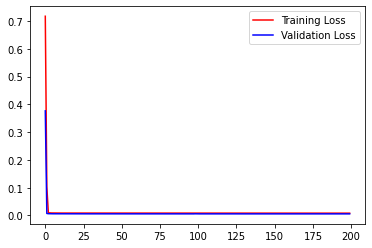

In [181]:
plt.plot(history1.history['loss'],color='r',label='Training Loss')
plt.plot(history1.history['val_loss'],color='b',label='Validation Loss')
plt.legend()
plt.show()

In [182]:
predictions = model.predict([xtestScaled,testCat])
print(predictions.shape)

(2804, 1)


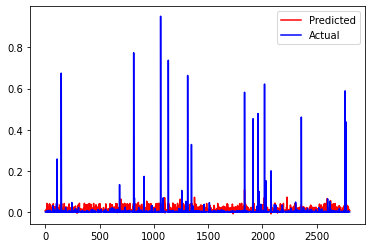

In [184]:
p=0
predictions = scaler_output.inverse_transform(predictions)
ytestScaled = scaler_output.inverse_transform(ytestScaled)
plt.plot(predictions[:,p],color='r',label='Predicted')
plt.plot(ytestScaled[:,p],color='b',label='Actual')
plt.legend()
plt.show()

In [171]:
np.log(-10)

<ipython-input-171-0d1208038d97>:1: RuntimeWarning: invalid value encountered in log
  np.log(-10)


nan

In [186]:
from sklearn.metrics import mean_squared_error as mse,mean_absolute_error as mae,r2_score
import math

n=0
math.sqrt(mse(ytestScaled[:,n],predictions[:,n]))*1000,r2_score(ytestScaled[:,n],predictions[:,n])*100



(41.65526375296208, 5.758021468767671)

# Trying to add all the vehicles

In [211]:
appended_data=[]
fileList = ['veh.'+str(i) for i in range(1,7)]
src = '../data/TfL dataset.xlsx'
for idx,file in enumerate(fileList):
    print(f'{file} started')
    df = pd.read_excel(src, sheet_name=file,skiprows=range(1,2))
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
    df['Vehicle'] = idx+1
    appended_data.append(df)
    print('-'*30)
appended_data = pd.concat(appended_data)

veh.1 started
------------------------------
veh.2 started
------------------------------
veh.3 started
------------------------------
veh.4 started
------------------------------
veh.5 started
------------------------------
veh.6 started
------------------------------


In [212]:
appended_data.to_excel('../data/Processed_data.xlsx')

# Working on the processed file

In [219]:
data = pd.read_excel('../data/Processed_data.xlsx')
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]
data.isnull().sum(),data.shape

(Test Time         0
 Roll Speed        0
 Eng. Speed        0
 CO Mass           0
 NOx Mass          0
 CO2 Mass          0
 driving cycle     0
 Vehicle           0
 dtype: int64,
 (84114, 8))

In [220]:
data.head()

,Test Time,Roll Speed,Eng. Speed,CO Mass,NOx Mass,CO2 Mass,driving cycle,Vehicle
0,0.1,0.056133,872.340,0.0,0.000004,0.328780,Urban-Free,1
1,1.1,0.019722,871.085,0.0,0.000004,0.332906,Urban-Free,1
2,2.1,0.046526,868.510,0.0,0.000004,0.331826,Urban-Free,1
3,3.1,0.035399,874.915,0.0,0.000005,0.326944,Urban-Free,1
4,4.1,0.049053,866.438,0.0,0.000002,0.324458,Urban-Free,1


In [221]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84114 entries, 0 to 84113
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Test Time       84114 non-null  float64
 1   Roll Speed      84114 non-null  float64
 2   Eng. Speed      84114 non-null  float64
 3   CO Mass         84114 non-null  float64
 4   NOx Mass        84114 non-null  float64
 5   CO2 Mass        84114 non-null  float64
 6   driving cycle   84114 non-null  object 
 7   Vehicle         84114 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 5.1+ MB


In [260]:
xtrain,xtest,ytrain,ytest = train_test_split(data[['Roll Speed','Eng. Speed','driving cycle ','Vehicle']].values,
                                            data[['CO Mass','NOx Mass','CO2 Mass']].values,shuffle=True,random_state=42,test_size=0.2)
print(f'xtrain shape is {xtrain.shape},xtest shape is {xtest.shape}')
print(f'ytrain shape is {ytrain.shape},ytest shape is {ytest.shape}')                                        

xtrain shape is (67291, 4),xtest shape is (16823, 4)
ytrain shape is (67291, 3),ytest shape is (16823, 3)


In [261]:
xtrain_numeric = xtrain[:,:2]
xtrain_categor = xtrain[:,2:]

xtest_numeric = xtest[:,:2]
xtest_categor = xtest[:,2:]

print(f'xtrain_numeric shape is {xtrain_numeric.shape},xtrain_categor shape is {xtrain_categor.shape}')
print(f'xtest_numeric shape is {xtest_numeric.shape},xtest_categor shape is {xtest_categor.shape}')

xtrain_numeric shape is (67291, 2),xtrain_categor shape is (67291, 2)
xtest_numeric shape is (16823, 2),xtest_categor shape is (16823, 2)


In [262]:
lbl_cycle = LabelEncoder()
lbl_cycle.fit(xtrain_categor[:,0])
drivingCycle_train = lbl_cycle.transform(xtrain_categor[:,0])
drivingCycle_test = lbl_cycle.transform(xtest_categor[:,0])

lbl_vehicle = LabelEncoder()
lbl_vehicle.fit(xtrain_categor[:,1])
vehicle_train = lbl_vehicle.transform(xtrain_categor[:,1])
vehicle_test = lbl_vehicle.transform(xtest_categor[:,1])

In [263]:
scaler_input = MinMaxScaler()
scaler_input.fit(xtrain_numeric)
xtrain_numeric = scaler_input.transform(xtrain_numeric)
xtest_numeric = scaler_input.transform(xtest_numeric)

In [264]:
xtrain_numeric=np.expand_dims(xtrain_numeric,axis=1)
xtest_numeric = np.expand_dims(xtest_numeric,axis=1)

In [265]:
drivingCycle_cats = len(list(np.unique(drivingCycle_train)))
vehicles_cats = len(list(np.unique(xtrain_categor[:,1])))

drivingCycle_embed = int(min(50,drivingCycle_cats+1/2))
vehicles_embed = int(min(50,vehicles_cats+1/2))

print(drivingCycle_cats,vehicles_cats)
print(drivingCycle_embed,vehicles_embed)

9 6
9 6


In [298]:
# categorical variable 
drivingCycle_catinput = keras.layers.Input(shape=(1,),name='Driving Cycle input')
drivingCycle_embedinput = keras.layers.Embedding(drivingCycle_cats,drivingCycle_embed)(drivingCycle_catinput)

vehicles_catinput = keras.layers.Input(shape=(1,),name='Vehicle Input')
vehicles_embedinput = keras.layers.Embedding(vehicles_cats,vehicles_embed)(vehicles_catinput)

# numerical variable
numerical_input = keras.layers.Input(shape=(1, 2), name='numeric_input')

# merged
merged = keras.layers.concatenate([numerical_input, drivingCycle_embedinput,vehicles_embedinput])
lstm_out0 = keras.layers.LSTM(32,return_sequences=True,activation='relu')(merged)
lstm_out1 = keras.layers.LSTM(32,return_sequences=True,activation='relu')(lstm_out0)
lstm_out2 = keras.layers.LSTM(32,return_sequences=True,activation='relu')(lstm_out1)
lstm_out3 = keras.layers.LSTM(32,return_sequences=True,activation='relu')(lstm_out2)
flattened = keras.layers.Flatten()(lstm_out3)
dense_out0 = keras.layers.Dense(32,activation='relu')(flattened)
dense_out1 = keras.layers.Dense(16,activation='relu')(dense_out0)
dense_out2 = keras.layers.Dense(8,activation='relu')(dense_out1)
dense_out3 = keras.layers.Dense(3,activation='relu')(dense_out2)

In [299]:
model = keras.Model([numerical_input, drivingCycle_catinput,vehicles_catinput], dense_out3)
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Driving Cycle input (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
Vehicle Input (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
numeric_input (InputLayer)      [(None, 1, 2)]       0                                            
__________________________________________________________________________________________________
embedding_25 (Embedding)        (None, 1, 9)         81          Driving Cycle input[0][0]        
___________________________________________________________________________________________

In [300]:
adam = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='mse',metrics=['mae'],optimizer=adam)

In [301]:
history = model.fit(x=[xtrain_numeric,drivingCycle_train,vehicle_train],y=ytrain,batch_size=32,validation_split=0.1,epochs=200)

.2534 - val_loss: 0.4693 - val_mae: 0.2614
Epoch 55/200
1893/1893 [==============================] - 5s 3ms/step - loss: 0.4477 - mae: 0.2518 - val_loss: 0.4527 - val_mae: 0.2512
Epoch 56/200
1893/1893 [==============================] - 5s 3ms/step - loss: 0.4461 - mae: 0.2511 - val_loss: 0.4560 - val_mae: 0.2468
Epoch 57/200
1893/1893 [==============================] - 5s 2ms/step - loss: 0.4484 - mae: 0.2501 - val_loss: 0.4493 - val_mae: 0.2472
Epoch 58/200
1893/1893 [==============================] - 4s 2ms/step - loss: 0.4544 - mae: 0.2517 - val_loss: 0.4516 - val_mae: 0.2512
Epoch 59/200
1893/1893 [==============================] - 5s 2ms/step - loss: 0.4352 - mae: 0.2470 - val_loss: 0.4547 - val_mae: 0.2453
Epoch 60/200
1893/1893 [==============================] - 5s 2ms/step - loss: 0.4377 - mae: 0.2497 - val_loss: 0.4454 - val_mae: 0.2470
Epoch 61/200
1893/1893 [==============================] - 5s 2ms/step - loss: 0.4498 - mae: 0.2503 - val_loss: 0.4442 - val_mae: 0.2499
Epoch

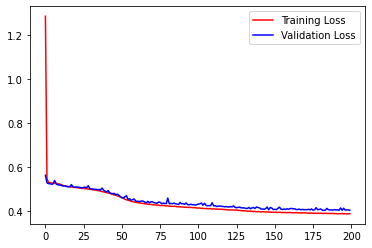

In [302]:
plt.plot(history.history['loss'],color='r',label='Training Loss')
plt.plot(history.history['val_loss'],color='b',label='Validation Loss')
plt.legend()
plt.show()

In [303]:
pred = model.predict([xtest_numeric,drivingCycle_test,vehicle_test])
print(pred.shape)

(16823, 3)


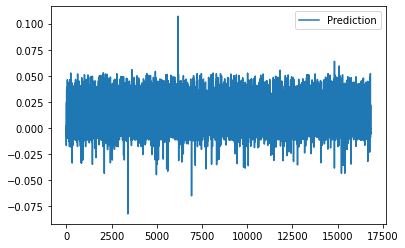

In [308]:
p=0
plt.plot(pred[:,p],label='Prediction')
# plt.plot(ytest[:,p],label='Actual')
plt.legend()
plt.show()

In [307]:
for i in range(0,3):
    print(f'for {i} RMSE is {math.sqrt(mse(ytest[:,i],pred[:,i]))*1000} and R2 is {r2_score(ytest[:,i],pred[:,i])*100}')

for 0 RMSE is 42.47031372642948 and R2 is 6.636101405400985
for 1 RMSE is 7.752626400320271 and R2 is 31.301430747483693
for 2 RMSE is 1074.0777912918109 and R2 is 75.18991000087173


In [140]:
comb = pd.concat([veh1.drop(['driving cycle '],axis=1),drivingCycles],axis=1)

In [92]:
comb.shape

(14019, 14)

In [93]:
comb.columns

Index(['Test Time', 'Roll Speed', 'CO Mass', 'NOx Mass', 'CO2 Mass',
       'Motorway-AM', 'Motorway-Free', 'Motorway-Inter', 'Suburban-Free',
       'Suburban-Inter', 'Urban- Inter', 'Urban-AM', 'Urban-Free',
       'suburban-AM'],
      dtype='object')

In [127]:
comb['CO Mass1'] = np.log(comb['CO Mass']+10)
comb['CO2 Mass'] = np.log(comb['CO2 Mass']+1)
comb['NOx Mass'] = np.log(comb['NOx Mass']+1)

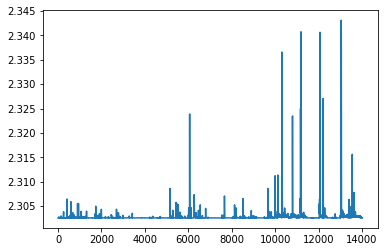

In [128]:
plt.plot(comb['CO Mass1'])

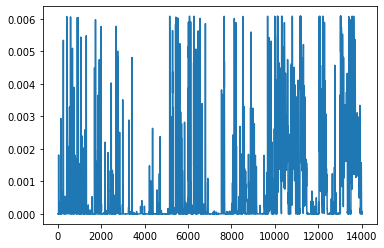

In [144]:
plt.plot(x)

In [143]:
from scipy import stats
x,_ = stats.boxcox(comb['CO Mass']+1)

In [125]:
comb['CO Mass']+10

1        10.000000
2        10.000000
3        10.000000
4        10.000000
5        10.000000
           ...    
14015    10.000004
14016    10.000004
14017    10.000004
14018    10.000002
14019    10.000001
Name: CO Mass, Length: 14019, dtype: float64

In [126]:
np.log(10)

2.302585092994046

<AxesSubplot:xlabel='Test Time'>

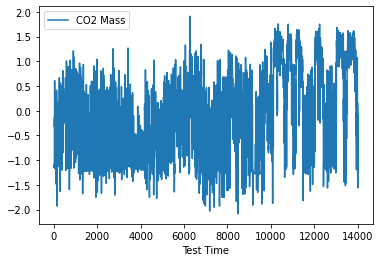

In [83]:
comb.plot(x='Test Time',y='CO2 Mass')

<AxesSubplot:xlabel='Test Time'>

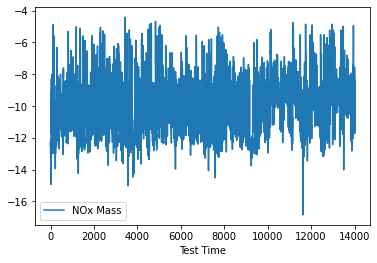

In [84]:
comb.plot(x='Test Time',y='NOx Mass')

In [130]:
xtrain,xtest,ytrain,ytest = train_test_split(comb.drop(['CO Mass', 'NOx Mass', 'CO2 Mass'],axis=1),comb[['CO Mass', 'NOx Mass', 'CO2 Mass']].values,shuffle=False,test_size=0.2)

In [131]:
print(f'xtrain shape is {xtrain.shape},xtest shape is {xtest.shape}')
print(f'ytrain shape is {ytrain.shape},ytest shape is {ytest.shape}')

xtrain shape is (11215, 11),xtest shape is (2804, 11)
ytrain shape is (11215, 3),ytest shape is (2804, 3)


In [132]:
scaler = MinMaxScaler()
scaler.fit(xtrain)
xtrainScaled = scaler.transform(xtrain)
xtestScaled = scaler.transform(xtest)

In [133]:
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

In [99]:
regressor = MultiOutputRegressor(SVR())
regressor.fit(xtrainScaled,ytrain)

MultiOutputRegressor(estimator=SVR())

In [101]:
regressor1 = DecisionTreeRegressor()
regressor1.fit(xtrainScaled,ytrain)

DecisionTreeRegressor()

In [100]:
regressor.score(xtrainScaled,ytrain)

-40.622011638789914

In [102]:
regressor1.score(xtrainScaled,ytrain)

1.0

In [103]:
predictions = regressor1.predict(xtestScaled)

In [104]:
predictions.shape

(2804, 3)

In [134]:
regressor2 = RandomForestRegressor()
regressor2.fit(xtrainScaled,ytrain)


RandomForestRegressor()

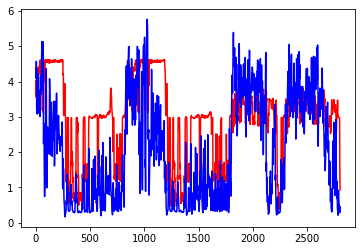

In [138]:
plt.plot(pred[:,2],color='r')
plt.plot(ytest[:,2],color='b')
plt.show()

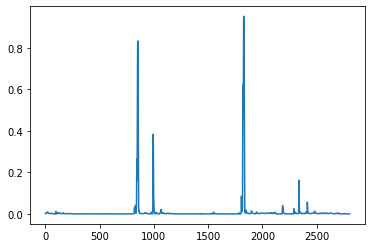

In [74]:
plt.plot(ytest[:,0])

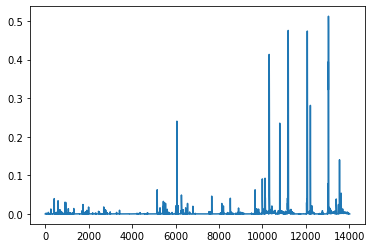

In [112]:
plt.plot(comb['CO Mass'])

In [90]:
np.log(0)

<ipython-input-90-f6e7c0610b57>:1: RuntimeWarning: divide by zero encountered in log
  np.log(0)


-inf

In [135]:
pred = regressor2.predict(xtestScaled)

In [139]:
regressor2.score(xtestScaled,ytest)

-4.050600769111223